In [1]:
import sys
sys.path.insert(1, '../SyMBac/') # Not needed if you installed SyMBac using pip
from multiprocessing import Pool, set_start_method
set_start_method('spawn')
import ray
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
import zarr
from numcodecs import Blosc
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.signal import find_peaks
import pandas as pd
from SyMBac.PSF import Camera
from skimage.measure import label
import psfmodels as psfm
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import tifffile

In [2]:
import cupy as cp
from cupyx.scipy.ndimage import convolve as cuconvolve

def convolve_rescale(image, kernel, rescale_factor, rescale_int):
    """
    Convolves an image with a kernel, and rescales it to the correct size.

    Parameters
    ----------
    image : 2D numpy array
        The image
    kernel : 2D numpy array
        The kernel
    rescale_factor : int
        Typicall 1/resize_amount. So 1/3 will scale the image down by a factor of 3. We do this because we render the image and kernel at high resolution, so that we can do the convolution at high resolution.
    rescale_int : bool
        If True, rescale the intensities between 0 and 1 and return a float32 numpy array of the convolved downscaled image.

    Returns
    -------
    outupt : 2D numpy array
        The output of the convolution rescale operation
    """

    output = cuconvolve(cp.array(image), cp.array(kernel),mode="constant")
    output = output.get()
    output = rescale(output, rescale_factor, anti_aliasing=False)

    if rescale_int:
        output = rescale_intensity(output.astype(np.float32), out_range=(0, 1))
    return output

def do_conv(x_pad, y_pad):
    ax1pad = x_pad
    ax0pad = y_pad
    cell_grid = np.pad(np.concatenate(
        [np.concatenate(
            [np.pad(cell,((ax0pad,ax0pad),(ax1pad,ax1pad)))]*grid_size
        )]*grid_size,
        axis = 1
    ),200)
    cell_grid_masks = label(cell_grid>0)
    mid_cell_mask = (cell_grid_masks==int(np.ceil((grid_size*grid_size)/2)))
    mid_top_cell_mask = (cell_grid_masks==int(grid_size//2))
    cell_grid = cell_grid * (~mid_top_cell_mask)
    cell_grid = cell_grid * (~mid_cell_mask)
    
    convolution = convolve_rescale(cell_grid.astype(float),kernel = conv_PSF, rescale_factor = 1, rescale_int = False)    
    convolution_intensity = np.sum(convolution * mid_cell_mask)
    raw_intensity = np.sum(cell_grid * mid_cell_mask)

    mid_top_convolution_intensity = np.sum(convolution * mid_top_cell_mask)
    
    
    return convolution, convolution_intensity, raw_intensity, cell_grid_masks, mid_top_convolution_intensity

In [3]:
def gaussian_2d(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp(- (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def lorentzian_2d(xdata_tuple, amplitude, xo, yo, gamma_x, gamma_y, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2)
    return (lorentz).ravel()

def log_mse(array1, array2):
    log_array1 = np.log(array1)
    log_array2 = np.log(array2)
    mse = np.mean((log_array1 - log_array2)**2)
    return mse

def lorentzian_2d_DoG(xdata_tuple, amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2)
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    return (lorentz * (gaussian_term_1 - gaussian_term_2)).ravel()

def log_mse(array1, array2):
    log_array1 = np.log(array1)
    log_array2 = np.log(array2)
    mse = np.mean((log_array1 - log_array2)**2)
    return mse

def asymmetric_moffat_2d(xdata_tuple, amplitude, xo, yo, alpha_x, alpha_y, beta, offset, sigma1, sigma2):
    (x, y) = xdata_tuple
    moffat_term = amplitude * (1 + ((x - xo)**2 / alpha_x**2) + ((y - yo)**2 / alpha_y**2)) ** (-beta) + offset
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    return (moffat_term * (gaussian_term_1 - gaussian_term_2)).ravel()


size: 104


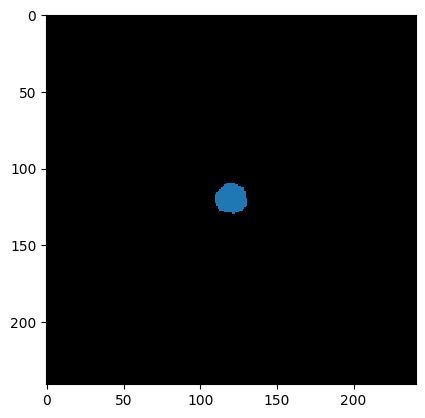

In [4]:
real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag.tif").astype(np.float32)
label_image = cle.voronoi_otsu_labeling(real_PSF)
imshow(label_image, labels=True)
stats = cle.statistics_of_labelled_pixels(real_PSF, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]
pix_mic_conv = 0.05
real_PSF = np.sum(real_PSF[int(df["mass_center_z"])-10:int(df["mass_center_z"])+10], axis = 0)
real_PSF = rescale(real_PSF, (0.0655/1.5) / pix_mic_conv  , anti_aliasing=True)
real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF -= real_PSF.min()
real_PSF = real_PSF / np.sum(real_PSF)



In [5]:
df["mass_center_z"]

0    45.066673
Name: mass_center_z, dtype: float32

In [6]:
from scipy.optimize import curve_fit

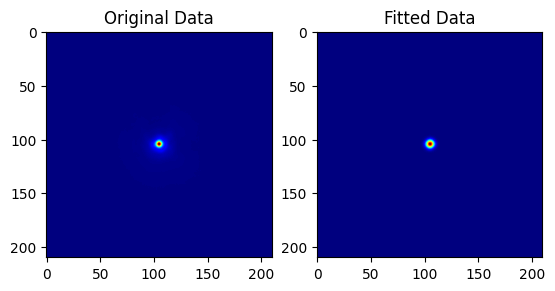

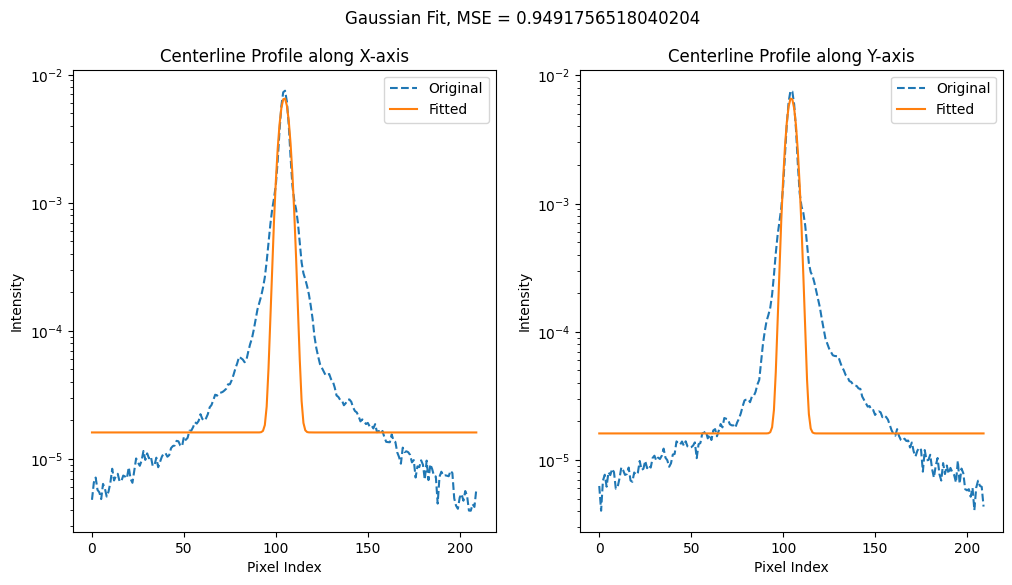

In [7]:

x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
initial_guess = (1, real_PSF.shape[0]/2, real_PSF.shape[1]/2, 1, 1, 0, 0)

popt, _ = curve_fit(gaussian_2d, (x, y), real_PSF.ravel(), p0=initial_guess)

data_fitted = gaussian_2d((x, y), *popt)
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(real_PSF, cmap=plt.cm.jet)
axes[0].set_title("Original Data")
axes[1].imshow(data_fitted, cmap=plt.cm.jet)
axes[1].set_title("Fitted Data")
plt.show()


# Calculate the centerline indices
center_x = int(real_PSF.shape[1] // 2)
center_y = int(real_PSF.shape[0] // 2)

# Extract the centerline profiles
centerline_x_original = real_PSF[center_y, :]
centerline_y_original = real_PSF[:, center_x]
centerline_x_fitted = data_fitted[center_y, :]
centerline_y_fitted = data_fitted[:, center_x]

# Plot the centerline profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Centerline along x-axis
axes[0].plot(centerline_x_original, label='Original', linestyle='--')
axes[0].plot(centerline_x_fitted, label='Fitted', linestyle='-')
axes[0].set_title('Centerline Profile along X-axis')
axes[0].set_xlabel('Pixel Index')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_yscale("log")

# Centerline along y-axis
axes[1].plot(centerline_y_original, label='Original', linestyle='--')
axes[1].plot(centerline_y_fitted, label='Fitted', linestyle='-')
axes[1].set_title('Centerline Profile along Y-axis')
axes[1].set_xlabel('Pixel Index')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_yscale("log")
MSE = (log_mse(centerline_x_original, centerline_x_fitted) + log_mse(centerline_y_original, centerline_y_fitted))/2
plt.suptitle(f"Gaussian Fit, MSE = {MSE}")

plt.show()


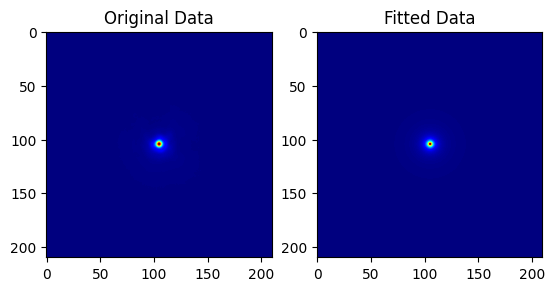

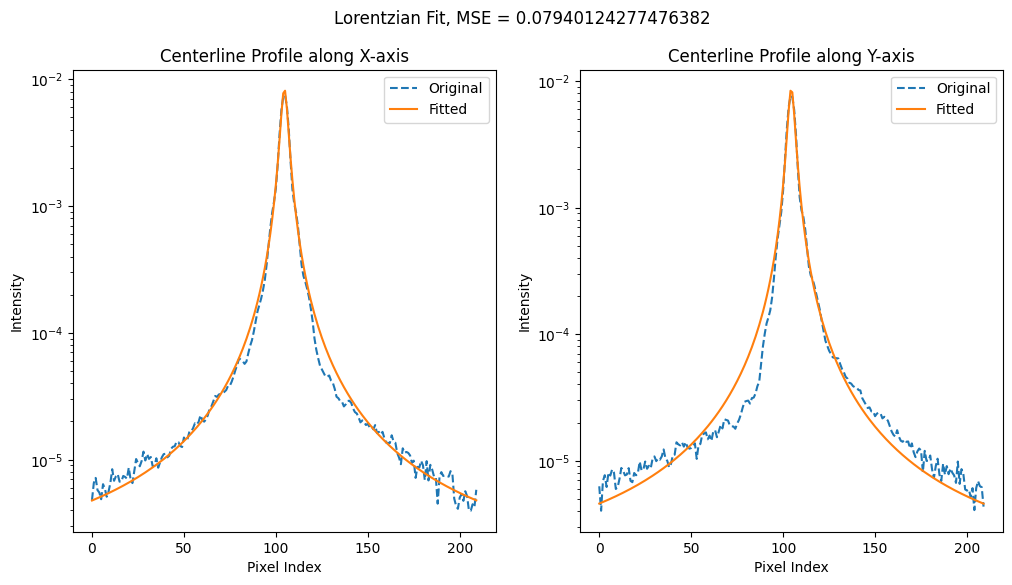

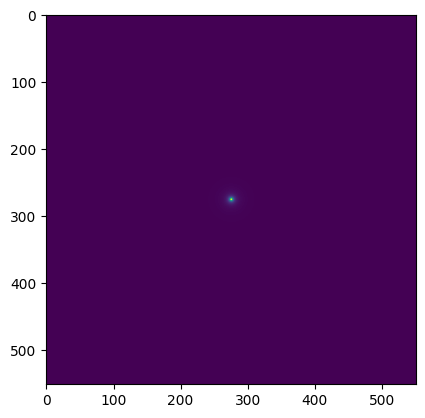

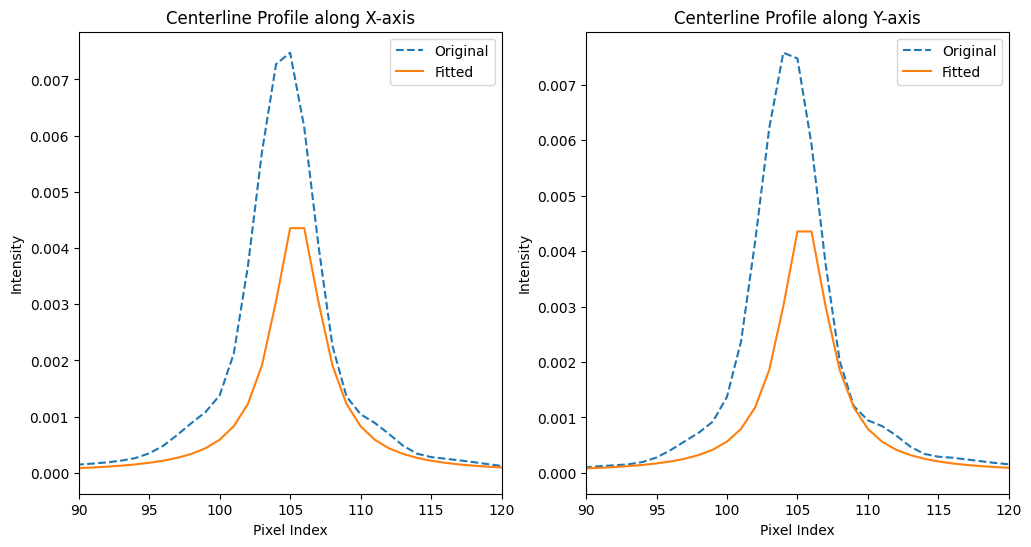

In [8]:

    
x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, gamma_x, gamma_y, offset]
initial_guess = (1, real_PSF.shape[1]/2, real_PSF.shape[0]/2, 1, 1, 0)

# Fit the 2D Lorentzian
popt, _ = curve_fit(lorentzian_2d, (x, y), real_PSF.ravel(), p0=initial_guess)

# Generate data from the optimal parameters
data_fitted = lorentzian_2d((x, y), *popt)

# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])

# (Continue with the plotting as in the previous example)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(real_PSF, cmap=plt.cm.jet)
axes[0].set_title("Original Data")
axes[1].imshow(data_fitted, cmap=plt.cm.jet)
axes[1].set_title("Fitted Data")
plt.show()


# Calculate the centerline indices
center_x = int(real_PSF.shape[1] // 2)
center_y = int(real_PSF.shape[0] // 2)

# Extract the centerline profiles
centerline_x_original = real_PSF[center_y, :]
centerline_y_original = real_PSF[:, center_x]
centerline_x_fitted = data_fitted[center_y, :]
centerline_y_fitted = data_fitted[:, center_x]

# Plot the centerline profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Centerline along x-axis
axes[0].plot(centerline_x_original, label='Original', linestyle='--')
axes[0].plot(centerline_x_fitted, label='Fitted', linestyle='-')
axes[0].set_title('Centerline Profile along X-axis')
axes[0].set_xlabel('Pixel Index')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_yscale("log")

# Centerline along y-axis
axes[1].plot(centerline_y_original, label='Original', linestyle='--')
axes[1].plot(centerline_y_fitted, label='Fitted', linestyle='-')
axes[1].set_title('Centerline Profile along Y-axis')
axes[1].set_xlabel('Pixel Index')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_yscale("log")

MSE = (log_mse(centerline_x_original, centerline_x_fitted) + log_mse(centerline_y_original, centerline_y_fitted))/2
plt.suptitle(f"Lorentzian Fit, MSE = {MSE}")

plt.show()



old_PSF_size = real_PSF.shape[0]
new_PSF_size = 700

# Area ratio
area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)

# Adjust the offset
new_offset = popt[-1] / area_ratio

## Replace the old offset in the parameter array with the new offset
#popt[-1] = new_offset
#x = np.linspace(0, moffat_PSF_size-1, moffat_PSF_size)
#y = np.linspace(0, moffat_PSF_size-1, moffat_PSF_size)
#x, y = np.meshgrid(x, y)
#popt[1] = popt[2] = new_PSF_size/2
# Generate the larger PSF
#lorentzian_PSF = lorentzian_2d((x, y), *popt)
#lorentzian_PSF = lorentzian_PSF.reshape(new_PSF_size, new_PSF_size)

lorentzian_PSF_size = 701
x = np.linspace(0, lorentzian_PSF_size-1, lorentzian_PSF_size)
y = np.linspace(0, lorentzian_PSF_size-1, lorentzian_PSF_size)
x, y = np.meshgrid(x, y)
popt[1] = popt[2] = lorentzian_PSF_size/2

# Area ratio
#new_PSF_size = moffat_PSF_size
#old_PSF_size = real_PSF.shape[1]
#area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)

# Adjust the offset
#new_offset = popt[-3] / area_ratio

# Replace the old offset in the parameter array with the new offset
#popt[-3] = new_offset

lorentzian_PSF = lorentzian_2d((x, y), *popt)
lorentzian_PSF = lorentzian_PSF.reshape(lorentzian_PSF_size, lorentzian_PSF_size)
lorentzian_PSF /= np.sum(lorentzian_PSF)

plt.imshow(lorentzian_PSF[75:-75,75:-75])
plt.show()

# Calculate the centerline indices
lorentzian_PSF_cropped = lorentzian_PSF[int((lorentzian_PSF_size-real_PSF.shape[0])/2):-int((lorentzian_PSF_size-real_PSF.shape[0])/2),int((lorentzian_PSF_size-real_PSF.shape[0])/2):-int((lorentzian_PSF_size-real_PSF.shape[0])/2)]
center_x = int(real_PSF.shape[1] // 2)
center_y = int(real_PSF.shape[0] // 2)

# Extract the centerline profiles
centerline_x_original = real_PSF[center_y, :]
centerline_y_original = real_PSF[:, center_x]
centerline_x_fitted = lorentzian_PSF_cropped[center_y, :]
centerline_y_fitted = lorentzian_PSF_cropped[:, center_x]

# Plot the centerline profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Centerline along x-axis
axes[0].plot(centerline_x_original, label='Original', linestyle='--')
axes[0].plot(centerline_x_fitted, label='Fitted', linestyle='-')
axes[0].set_title('Centerline Profile along X-axis')
axes[0].set_xlabel('Pixel Index')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_xlim(90, 120)
# Centerline along y-axis
axes[1].plot(centerline_y_original, label='Original', linestyle='--')
axes[1].plot(centerline_y_fitted, label='Fitted', linestyle='-')
axes[1].set_title('Centerline Profile along Y-axis')
axes[1].set_xlabel('Pixel Index')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_xlim(90, 120)
plt.show()


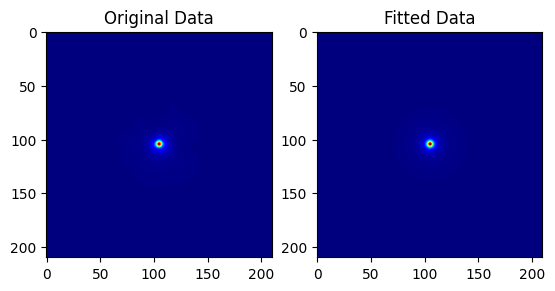

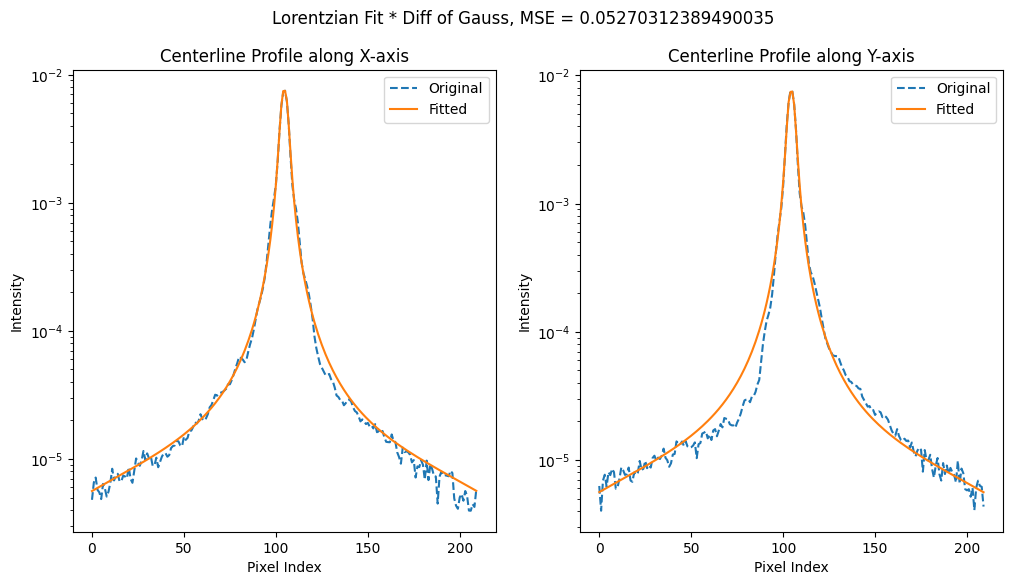

x log MSE  0.028508457085389856
y log MSE  0.07689779070441084


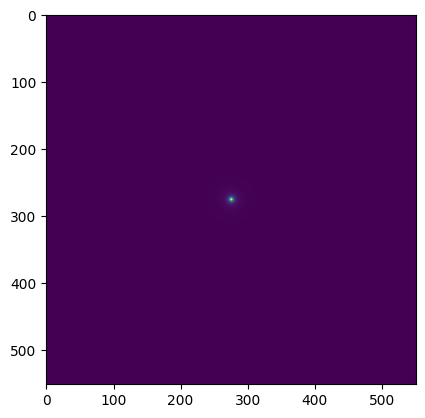

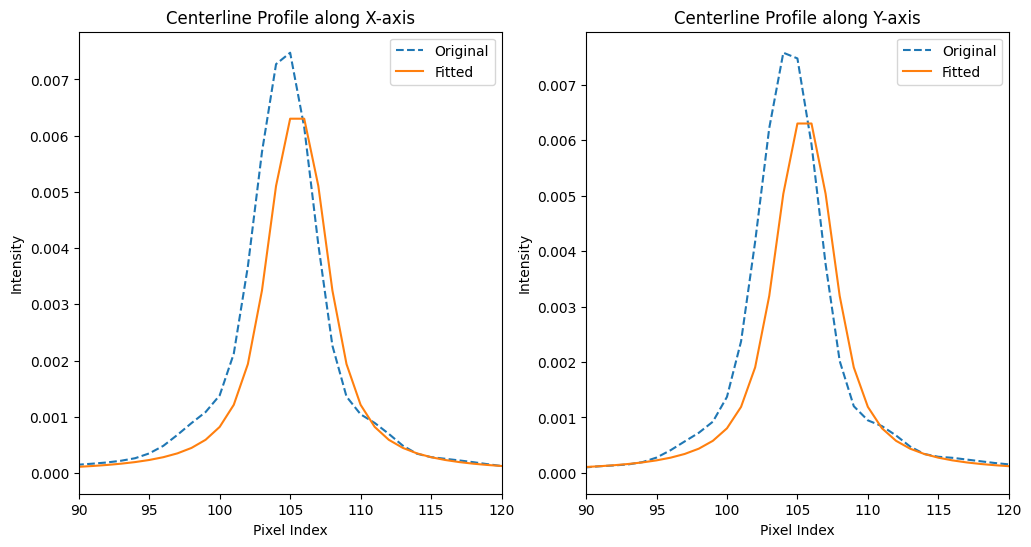

In [9]:

    
x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, gamma_x, gamma_y, offset]
initial_guess = (1, real_PSF.shape[1]/2, real_PSF.shape[0]/2, 1, 1, 1, 2, 0)

# Fit the 2D Lorentzian
popt, _ = curve_fit(lorentzian_2d_DoG, (x, y), real_PSF.ravel(), p0=initial_guess)

# Generate data from the optimal parameters
data_fitted = lorentzian_2d_DoG((x, y), *popt)

# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])

# (Continue with the plotting as in the previous example)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(real_PSF, cmap=plt.cm.jet)
axes[0].set_title("Original Data")
axes[1].imshow(data_fitted, cmap=plt.cm.jet)
axes[1].set_title("Fitted Data")
plt.show()


# Calculate the centerline indices
center_x = int(real_PSF.shape[1] // 2)
center_y = int(real_PSF.shape[0] // 2)

# Extract the centerline profiles
centerline_x_original = real_PSF[center_y, :]
centerline_y_original = real_PSF[:, center_x]
centerline_x_fitted = data_fitted[center_y, :]
centerline_y_fitted = data_fitted[:, center_x]

# Plot the centerline profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Centerline along x-axis
axes[0].plot(centerline_x_original, label='Original', linestyle='--')
axes[0].plot(centerline_x_fitted, label='Fitted', linestyle='-')
axes[0].set_title('Centerline Profile along X-axis')
axes[0].set_xlabel('Pixel Index')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_yscale("log")

# Centerline along y-axis
axes[1].plot(centerline_y_original, label='Original', linestyle='--')
axes[1].plot(centerline_y_fitted, label='Fitted', linestyle='-')
axes[1].set_title('Centerline Profile along Y-axis')
axes[1].set_xlabel('Pixel Index')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_yscale("log")
MSE = (log_mse(centerline_x_original, centerline_x_fitted) + log_mse(centerline_y_original, centerline_y_fitted))/2
plt.suptitle(f"Lorentzian Fit * Diff of Gauss, MSE = {MSE}")
plt.show()

print("x log MSE ", log_mse(centerline_x_original, centerline_x_fitted))
print("y log MSE ", log_mse(centerline_y_original, centerline_y_fitted))


old_PSF_size = real_PSF.shape[0]
new_PSF_size = 700

# Area ratio
area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)

# Adjust the offset
new_offset = popt[-1] / area_ratio

## Replace the old offset in the parameter array with the new offset
#popt[-1] = new_offset
#x = np.linspace(0, moffat_PSF_size-1, moffat_PSF_size)
#y = np.linspace(0, moffat_PSF_size-1, moffat_PSF_size)
#x, y = np.meshgrid(x, y)
#popt[1] = popt[2] = new_PSF_size/2
# Generate the larger PSF
#lorentzian_PSF = lorentzian_2d((x, y), *popt)
#lorentzian_PSF = lorentzian_PSF.reshape(new_PSF_size, new_PSF_size)

lorentzian_PSF_size = 701
x = np.linspace(0, lorentzian_PSF_size-1, lorentzian_PSF_size)
y = np.linspace(0, lorentzian_PSF_size-1, lorentzian_PSF_size)
x, y = np.meshgrid(x, y)
popt[1] = popt[2] = lorentzian_PSF_size/2

# Area ratio
#new_PSF_size = moffat_PSF_size
#old_PSF_size = real_PSF.shape[1]
#area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)

# Adjust the offset
#new_offset = popt[-3] / area_ratio

# Replace the old offset in the parameter array with the new offset
#popt[-3] = new_offset

lorentzian_PSF = lorentzian_2d_DoG((x, y), *popt)
lorentzian_PSF = lorentzian_PSF.reshape(lorentzian_PSF_size, lorentzian_PSF_size)
lorentzian_PSF /= np.sum(lorentzian_PSF)
lorentzian_PSF-=lorentzian_PSF.min()
plt.imshow(lorentzian_PSF[75:-75,75:-75])
plt.show()

# Calculate the centerline indices
lorentzian_PSF_cropped = lorentzian_PSF[int((lorentzian_PSF_size-real_PSF.shape[0])/2):-int((lorentzian_PSF_size-real_PSF.shape[0])/2),int((lorentzian_PSF_size-real_PSF.shape[0])/2):-int((lorentzian_PSF_size-real_PSF.shape[0])/2)]
center_x = int(real_PSF.shape[1] // 2)
center_y = int(real_PSF.shape[0] // 2)

# Extract the centerline profiles
centerline_x_original = real_PSF[center_y, :]
centerline_y_original = real_PSF[:, center_x]
centerline_x_fitted = lorentzian_PSF_cropped[center_y, :]
centerline_y_fitted = lorentzian_PSF_cropped[:, center_x]

# Plot the centerline profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Centerline along x-axis
axes[0].plot(centerline_x_original, label='Original', linestyle='--')
axes[0].plot(centerline_x_fitted, label='Fitted', linestyle='-')
axes[0].set_title('Centerline Profile along X-axis')
axes[0].set_xlabel('Pixel Index')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_xlim(90, 120)
# Centerline along y-axis
axes[1].plot(centerline_y_original, label='Original', linestyle='--')
axes[1].plot(centerline_y_fitted, label='Fitted', linestyle='-')
axes[1].set_title('Centerline Profile along Y-axis')
axes[1].set_xlabel('Pixel Index')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_xlim(90, 120)

plt.show()


In [10]:
tifffile.imwrite("lorentzian_PSF_515nm_2201px.tiff", lorentzian_PSF)

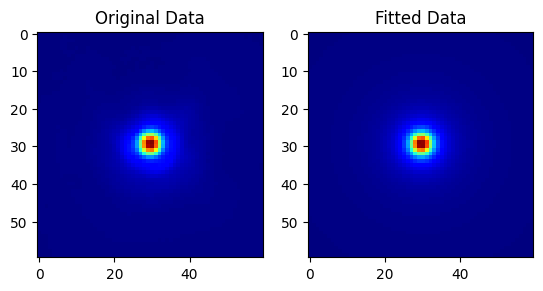

x log MSE  0.02797701387829984
y log MSE  0.0829650655320593


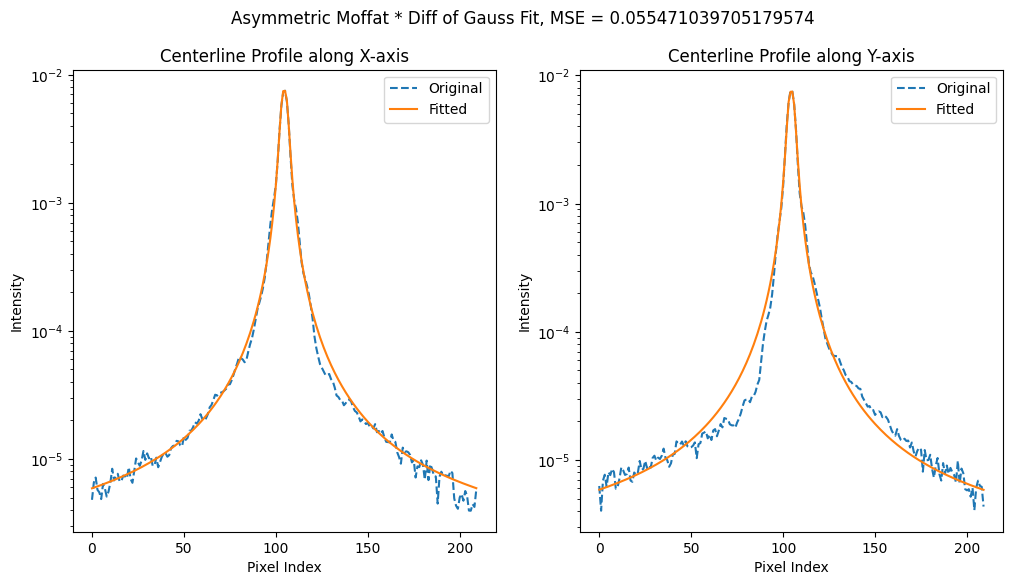

1.835133445365437


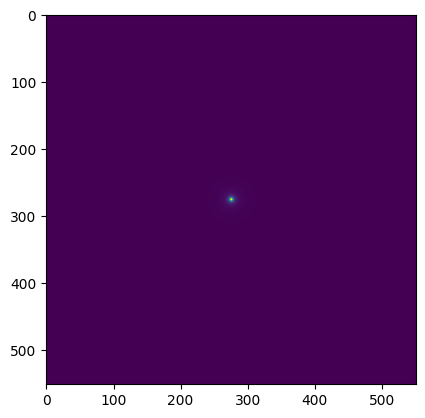

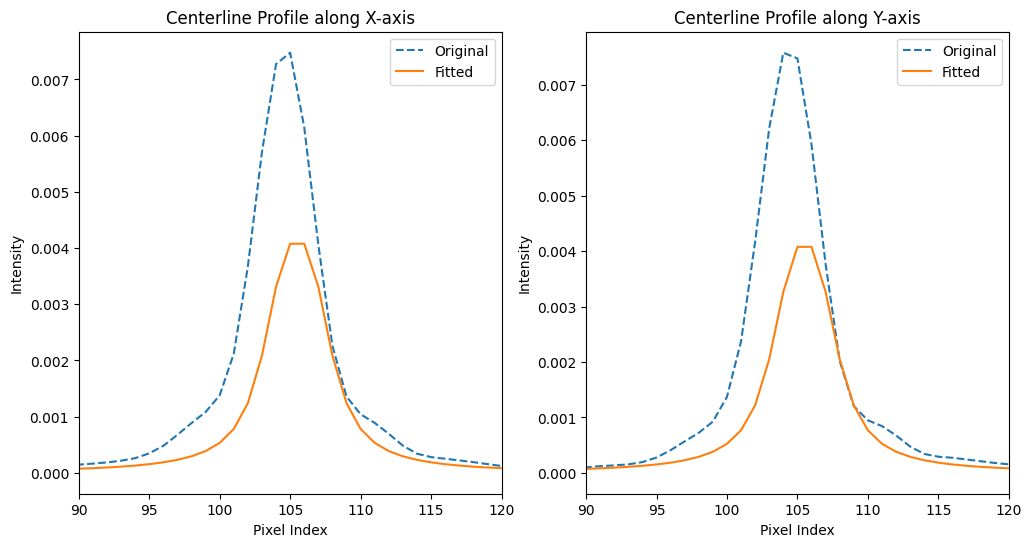

In [11]:


x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, alpha_x, alpha_y, beta, offset]
initial_guess = (1, real_PSF.shape[1]/2, real_PSF.shape[0]/2, 1, 1, 1, 0, 3, 1)

# Fit the 2D Asymmetric Moffat
popt, _ = curve_fit(asymmetric_moffat_2d, (x, y), real_PSF.ravel(), p0=initial_guess)

# Generate data from the optimal parameters
data_fitted = asymmetric_moffat_2d((x, y), *popt)

# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])

# (Continue with the plotting as in the previous examples)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(real_PSF[75:-75,75:-75], cmap=plt.cm.jet, vmin = 0, vmax = real_PSF.max())
axes[0].set_title("Original Data")
axes[1].imshow(data_fitted[75:-75,75:-75], cmap=plt.cm.jet, vmin = 0, vmax = real_PSF.max())
axes[1].set_title("Fitted Data")
plt.show()

# Calculate the centerline indices
center_x = int(real_PSF.shape[1] // 2)
center_y = int(real_PSF.shape[0] // 2)

# Extract the centerline profiles
centerline_x_original = real_PSF[center_y, :]
centerline_y_original = real_PSF[:, center_x]
centerline_x_fitted = data_fitted[center_y, :]
centerline_y_fitted = data_fitted[:, center_x]

print("x log MSE ", log_mse(centerline_x_original, centerline_x_fitted))
print("y log MSE ", log_mse(centerline_y_original, centerline_y_fitted))

# Plot the centerline profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Centerline along x-axis
axes[0].plot(centerline_x_original, label='Original', linestyle='--')
axes[0].plot(centerline_x_fitted, label='Fitted', linestyle='-')
axes[0].set_title('Centerline Profile along X-axis')
axes[0].set_xlabel('Pixel Index')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_yscale("log")

# Centerline along y-axis
axes[1].plot(centerline_y_original, label='Original', linestyle='--')
axes[1].plot(centerline_y_fitted, label='Fitted', linestyle='-')
axes[1].set_title('Centerline Profile along Y-axis')
axes[1].set_xlabel('Pixel Index')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_yscale("log")
MSE = (log_mse(centerline_x_original, centerline_x_fitted) + log_mse(centerline_y_original, centerline_y_fitted))/2
plt.suptitle(f"Asymmetric Moffat * Diff of Gauss Fit, MSE = {MSE}")
plt.show()


moffat_PSF_size = 701
x = np.linspace(0, moffat_PSF_size-1, moffat_PSF_size)
y = np.linspace(0, moffat_PSF_size-1, moffat_PSF_size)
x, y = np.meshgrid(x, y)
popt[1] = popt[2] = moffat_PSF_size/2

# Area ratio
#new_PSF_size = moffat_PSF_size
#old_PSF_size = real_PSF.shape[1]
#area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)

# Adjust the offset
#new_offset = popt[-3] / area_ratio

# Replace the old offset in the parameter array with the new offset
#popt[-3] = new_offset

moffat_PSF = asymmetric_moffat_2d((x, y), *popt)
moffat_PSF = moffat_PSF.reshape(moffat_PSF_size, moffat_PSF_size)
print(moffat_PSF.sum())
moffat_PSF = moffat_PSF/np.sum(moffat_PSF)

#moffat_PSF = moffat_PSF/moffat_PSF.sum()
plt.imshow(moffat_PSF[75:-75,75:-75])
plt.show()

# Calculate the centerline indices
moffat_PSF_cropped = moffat_PSF[int((moffat_PSF_size-real_PSF.shape[0])/2):-int((moffat_PSF_size-real_PSF.shape[0])/2),int((moffat_PSF_size-real_PSF.shape[0])/2):-int((moffat_PSF_size-real_PSF.shape[0])/2)]
center_x = int(real_PSF.shape[1] // 2)
center_y = int(real_PSF.shape[0] // 2)

# Extract the centerline profiles
centerline_x_original = real_PSF[center_y, :]
centerline_y_original = real_PSF[:, center_x]
centerline_x_fitted = moffat_PSF_cropped[center_y, :]
centerline_y_fitted = moffat_PSF_cropped[:, center_x]

# Plot the centerline profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Centerline along x-axis
axes[0].plot(centerline_x_original, label='Original', linestyle='--')
axes[0].plot(centerline_x_fitted, label='Fitted', linestyle='-')
axes[0].set_title('Centerline Profile along X-axis')
axes[0].set_xlabel('Pixel Index')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_xlim(90, 120)
# Centerline along y-axis
axes[1].plot(centerline_y_original, label='Original', linestyle='--')
axes[1].plot(centerline_y_fitted, label='Fitted', linestyle='-')
axes[1].set_title('Centerline Profile along Y-axis')
axes[1].set_xlabel('Pixel Index')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_xlim(90, 120)

plt.show()


In [12]:
resize_amount = 1

fit_PSF_model = False
if fit_PSF_model:
    radius = real_PSF.shape[0]/2
    wavelength = 0.6
    NA = 1.49
    n = 1.518
    apo_sigma = 11
    
    #
    
    FL_PSF = PSF_generator(
        radius = radius,
        wavelength = wavelength,
        NA = NA,
        n = n,
        resize_amount = resize_amount,
        pix_mic_conv = pix_mic_conv,
        apo_sigma = apo_sigma,
        mode="3d fluo",
        condenser = "Ph3",
        z_height = int(round(1/pix_mic_conv)),
        pz = 0.5,
        working_distance = 170
    )
    FL_PSF.calculate_PSF()
    FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
    FL_PSF.kernel = FL_PSF.kernel/np.sum(FL_PSF.kernel)
    FL_PSF.kernel.shape
    
    
    def make_PSF(params):
        NA, ti0, ni, ni0, wvl, pz, tg, tg0, ng, ng0 = params
        if NA > ni:
            NA = ni-0.01
        synth_PSF = psfm.make_psf(
            z = int(round(1/pix_mic_conv)), 
            nx = radius*2, 
            dxy=pix_mic_conv, 
            dz=pix_mic_conv, 
            pz=pz, 
            ni=ni, 
            ni0 = ni0,
            wvl=wvl,
            NA= NA, 
            model="scalar",
            ti0 = ti0,
            tg = tg,
            tg0 = tg0,
            ng = ng,
            ng0 = ng0,
        )
        synth_PSF = synth_PSF.sum(axis=0)
        synth_PSF = synth_PSF/synth_PSF.sum()
        return synth_PSF
    
    
    
    params_init = [1.49, 170, 1.5, 1.5, 0.6, 0.5,  100, 100, 1.5, 1.5]
    dimensions = [(1, 1.49), (100,200), (1.4, 1.6), (1.4, 1.6), (0.5,0.7), (0., 2.), (60, 200), (60, 200), (1.4, 1.6), (1.4, 1.6)]
    
    from skopt import gp_minimize
    def neg_log_likelihood(params, z_data):
        z_model = make_PSF(params)
        nll = -np.sum(z_data * np.log(z_model) - z_model)
        if nll is np.nan:
            return 1000
        return nll
    
    result = gp_minimize(
        lambda x: neg_log_likelihood(x, real_PSF),
        x0=params_init,
        dimensions=dimensions,
        n_calls=100,
        n_jobs=-1,
    )
    
    result
    
    from scipy.optimize import least_squares
    
    def objective(params, z):
        return (z - make_PSF(params)).flatten()
    
    bounds = ([x[0] for x in dimensions], [x[1] for x in dimensions])
    
    res = least_squares(neg_log_likelihood, params_init, args=[real_PSF], bounds = bounds, method = "dogbox")
    
    print(res.x)
    
    plt.imshow(real_PSF - make_PSF(res.x))
    np.sum(real_PSF - make_PSF(res.x))
    
    real_PSF.sum()
    
    params =  [np.random.uniform(low, high) for (low, high) in dimensions]
    np.sum(objective(params, real_PSF))
    
    def random_PSF_check():
        params = [np.random.uniform(low, high) for (low, high) in dimensions]
        return params, np.sum(neg_log_likelihood(params, real_PSF))
    
    x = 0
    while x is not np.nan:
        params, x = random_PSF_check()
    
    plt.imshow(make_PSF(res.x)**(1/2), cmap="turbo")

In [13]:
cell_length = 3
cell_width = 1

raster_cell_length = cell_length/pix_mic_conv * resize_amount
raster_cell_width = cell_width/pix_mic_conv * resize_amount
cell = raster_cell(raster_cell_length, raster_cell_width, separation=0)

In [32]:
grid_size = 10
convolution, convolution_intensity, raw_intensity, cell_grid_masks, mid_top_convolution_intensity = do_conv(25, 12)

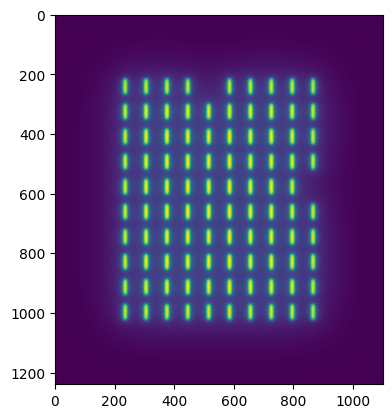

In [33]:
plt.imshow(convolution)

In [34]:
tifffile.imsave("convolution_example.tiff", convolution)

In [14]:
grid_size = 31

In [15]:
ax0pad = 0
ax1pad = 0

In [16]:
conv_PSF = lorentzian_PSF

single_cell = np.pad(cell,300)
single_cell_conv = convolve_rescale(single_cell.astype(float),kernel = conv_PSF, rescale_factor = 1, rescale_int = False)
ss_conv_intensity = np.sum(
    (single_cell > 0) * single_cell_conv
)

In [17]:
spacing = 10

In [18]:
data = []
mid_top_data = []
imgs = []
for x_pad in tqdm(range(0,140+spacing,spacing)):
    for y_pad in tqdm(range(0,140+spacing,spacing)):
        convolution, convolution_intensity, raw_intensity, cell_grid_masks, mid_top_convolution_intensity = do_conv(x_pad, y_pad)
        data.append(
            [
                x_pad*2*pix_mic_conv, y_pad*2*pix_mic_conv, convolution_intensity/ss_conv_intensity
            ]
        )
        mid_top_data.append(
            [
                x_pad*2*pix_mic_conv, y_pad*2*pix_mic_conv, mid_top_convolution_intensity/ss_conv_intensity
            ]
        )
        imgs.append(convolution)
    #plt.figure(figsize=(20,20))
    #plt.imshow(imgs[-1])
    #plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
from joblib import Parallel, delayed

def parallel_function(x_pad, y_pad):
    convolution, convolution_intensity, raw_intensity, cell_grid_masks, mid_top_convolution_intensity = do_conv(x_pad, y_pad)
    data = [
        x_pad*2*pix_mic_conv, y_pad*2*pix_mic_conv, convolution_intensity/ss_conv_intensity
    ]
    mid_top_data = [
        x_pad*2*pix_mic_conv, y_pad*2*pix_mic_conv, mid_top_convolution_intensity/ss_conv_intensity
    ]
    img = convolution
    
    return data, mid_top_data, img

parameters = [(x, y) for x in range(0, 140+spacing, spacing) for y in range(0, 140+spacing, spacing)]
results = Parallel(n_jobs=-1)(delayed(parallel_function)(x_pad, y_pad) for x_pad, y_pad in tqdm(parameters))
data = [item[0] for item in results]
mid_top_data = [item[1] for item in results]
imgs = [item[2] for item in results]

  0%|          | 0/225 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


OutOfMemoryError: Out of memory allocating 236,880,384 bytes (allocated so far: 244,743,680 bytes).

In [51]:
df = pd.read_pickle("lorentzian_convolution.pickle")
df["x"] += 1
df["y"] += 1

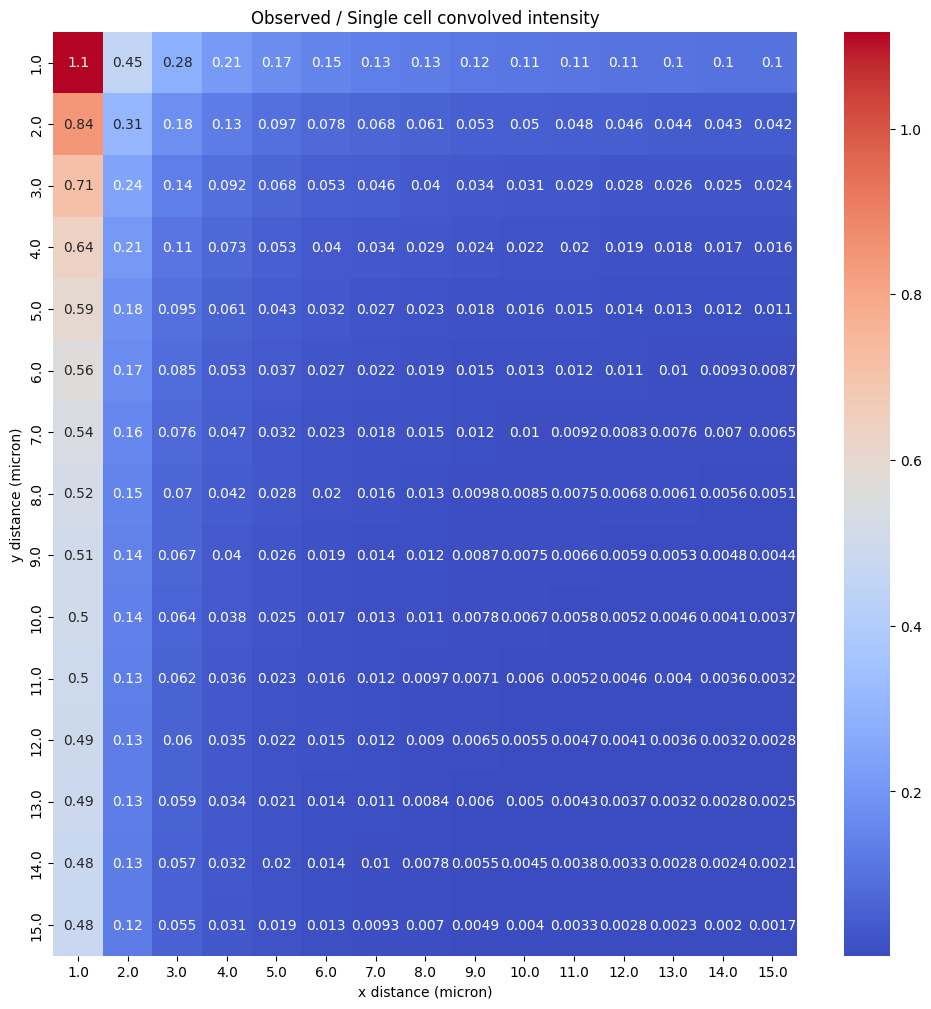

In [52]:
import seaborn as sns
# Convert to DataFrame
#df = pd.DataFrame(data, columns=['x', 'y', 'data'])

# Create a 2D array initialized with NaNs
unique_x = np.sort(df['x'].unique())
unique_y = np.sort(df['y'].unique())
heatmap_data = np.empty((len(unique_x), len(unique_y)))
heatmap_data[:] = np.nan

# Populate 2D array with your data
for row in df.itertuples():
    x_idx = np.where(unique_x == row.x)[0][0]
    y_idx = np.where(unique_y == row.y)[0][0]
    heatmap_data[x_idx, y_idx] = row.data

# Transpose the 2D array
heatmap_data_transposed = heatmap_data.T

# Create heatmap with transposed data
plt.figure(figsize=(12,12))
sns.heatmap(heatmap_data_transposed, xticklabels=unique_x, yticklabels=unique_y, annot=True, cmap='coolwarm')
plt.xlabel('x distance (micron)')
plt.ylabel('y distance (micron)')
plt.title("Observed / Single cell convolved intensity")
plt.show()

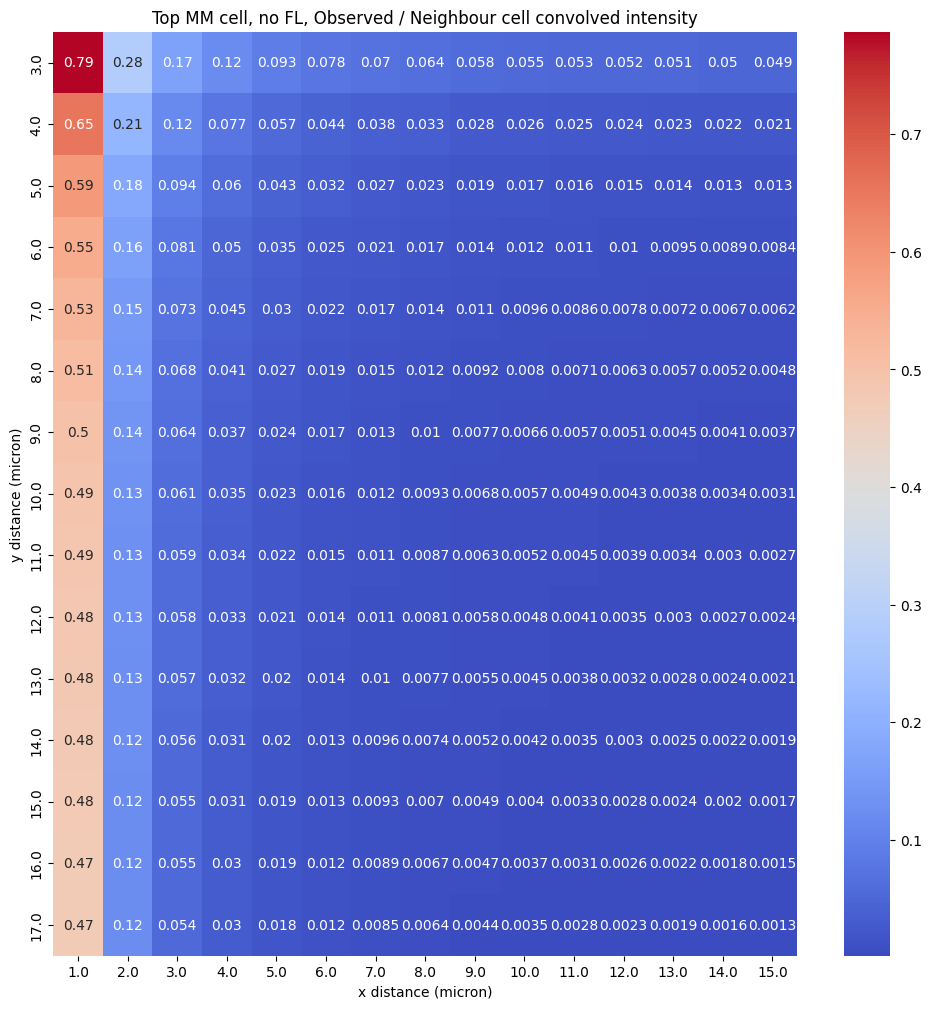

In [62]:
import seaborn as sns
# Convert to DataFrame
mid_top_df = pd.DataFrame(mid_top_data, columns=['x', 'y', 'data'])
mid_top_df["x"] += 1
mid_top_df["y"] += 3
#mid_top_df.to_pickle("lorentzian_convolution_mid_top.pickle")
# Create a 2D array initialized with NaNs
unique_x = np.sort(mid_top_df['x'].unique())
unique_y = np.sort(mid_top_df['y'].unique())
heatmap_data = np.empty((len(unique_x), len(unique_y)))
heatmap_data[:] = np.nan

# Populate 2D array with your data
for row in mid_top_df.itertuples():
    x_idx = np.where(unique_x == row.x)[0][0]
    y_idx = np.where(unique_y == row.y)[0][0]
    heatmap_data[x_idx, y_idx] = row.data

# Transpose the 2D array
heatmap_data_transposed = heatmap_data.T

# Create heatmap with transposed data
plt.figure(figsize=(12,12))
sns.heatmap(heatmap_data_transposed, xticklabels=unique_x, yticklabels=unique_y, annot=True, cmap='coolwarm')
plt.xlabel('x distance (micron)')
plt.ylabel('y distance (micron)')
plt.title("Top MM cell, no FL, Observed / Neighbour cell convolved intensity")
plt.show()

In [28]:
#df.to_pickle("lorentzian_convolution.pickle")

In [29]:
from copy import deepcopy
lorentzian_data = deepcopy(df)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

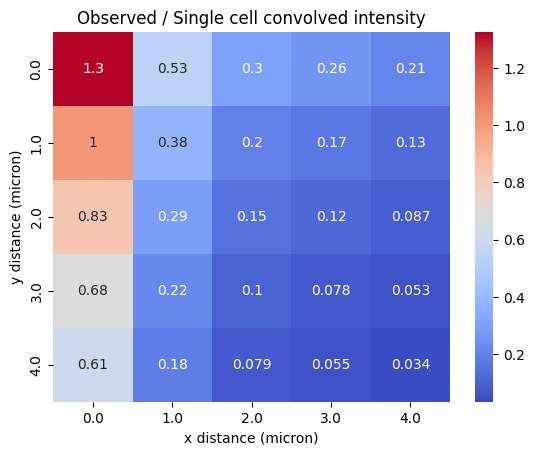

In [20]:
conv_PSF = real_PSF

single_cell = np.pad(cell,300)
single_cell_conv = convolve_rescale(single_cell.astype(float),kernel = conv_PSF, rescale_factor = 1, rescale_int = False)
#plt.imshow(single_cell_conv)

ss_conv_intensity = np.sum(
    (single_cell > 0) * single_cell_conv
)

data = []
mid_top_data = []
imgs = []
spacing = 10
for x_pad in tqdm(range(0,40+spacing,spacing)):
    for y_pad in tqdm(range(0,40+spacing,spacing)):
        convolution, convolution_intensity, raw_intensity, cell_grid_masks, mid_top_convolution_intensity = do_conv(x_pad, y_pad)
        data.append(
            [
                x_pad*2*pix_mic_conv, y_pad*2*pix_mic_conv, convolution_intensity/ss_conv_intensity
            ]
        )
        mid_top_data.append(
            [
                x_pad*2*pix_mic_conv, y_pad*2*pix_mic_conv, mid_top_convolution_intensity/ss_conv_intensity
            ]
        )
        imgs.append(convolution)
    #plt.figure(figsize=(20,20))
    #plt.imshow(imgs[-1])
    #plt.show()

import seaborn as sns
# Convert to DataFrame
df = pd.DataFrame(data, columns=['x', 'y', 'data'])

# Create a 2D array initialized with NaNs
unique_x = np.sort(df['x'].unique())
unique_y = np.sort(df['y'].unique())
heatmap_data = np.empty((len(unique_x), len(unique_y)))
heatmap_data[:] = np.nan

# Populate 2D array with your data
for row in df.itertuples():
    x_idx = np.where(unique_x == row.x)[0][0]
    y_idx = np.where(unique_y == row.y)[0][0]
    heatmap_data[x_idx, y_idx] = row.data

# Transpose the 2D array
heatmap_data_transposed = heatmap_data.T

# Create heatmap with transposed data
sns.heatmap(heatmap_data_transposed, xticklabels=unique_x, yticklabels=unique_y, annot=True, cmap='coolwarm')
plt.xlabel('x distance (micron)')
plt.ylabel('y distance (micron)')
plt.title("Observed / Single cell convolved intensity")
plt.show()


In [18]:
empirical_data = deepcopy(df)

Text(0, 0.5, 'Overestimation factor')

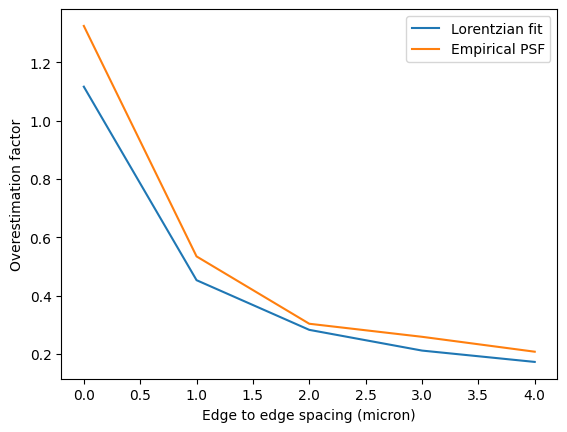

In [19]:
plt.plot(moffat_data["data"], label = "Lorentzian fit")
plt.plot(empirical_data["data"], label = "Empirical PSF")
plt.legend()
plt.xlabel("Edge to edge spacing (micron)")
plt.ylabel("Overestimation factor")

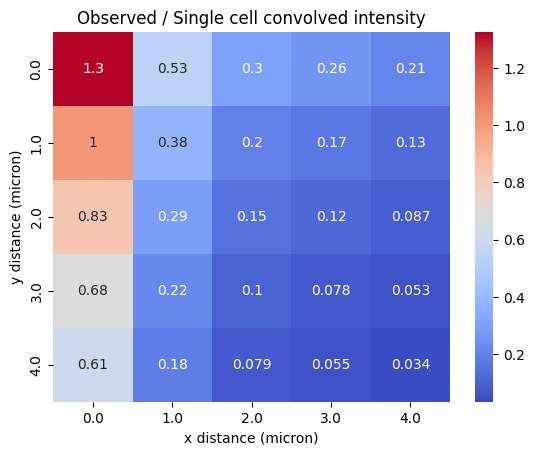

In [23]:
# Convert to DataFrame
df = pd.DataFrame(data, columns=['x', 'y', 'data'])

# Create a 2D array initialized with NaNs
unique_x = np.sort(df['x'].unique())
unique_y = np.sort(df['y'].unique())
heatmap_data = np.empty((len(unique_x), len(unique_y)))
heatmap_data[:] = np.nan

# Populate 2D array with your data
for row in df.itertuples():
    x_idx = np.where(unique_x == row.x)[0][0]
    y_idx = np.where(unique_y == row.y)[0][0]
    heatmap_data[x_idx, y_idx] = row.data

# Transpose the 2D array
heatmap_data_transposed = heatmap_data.T

# Create heatmap with transposed data
sns.heatmap(heatmap_data_transposed, xticklabels=unique_x, yticklabels=unique_y, annot=True, cmap='coolwarm')
plt.xlabel('x distance (micron)')
plt.ylabel('y distance (micron)')
plt.title("Observed / Single cell convolved intensity")
plt.show()


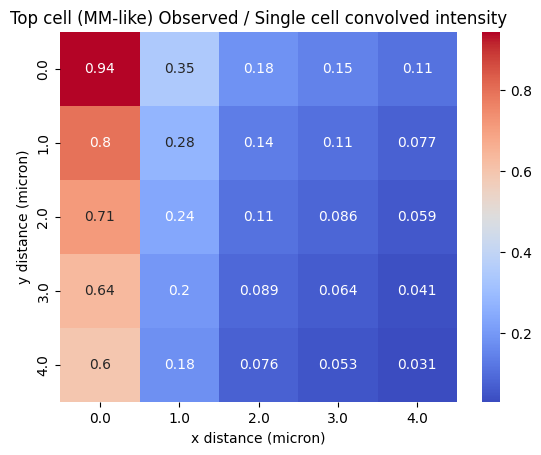

In [24]:
import seaborn as sns
# Convert to DataFrame
df = pd.DataFrame(mid_top_data, columns=['x', 'y', 'data'])

# Create a 2D array initialized with NaNs
unique_x = np.sort(df['x'].unique())
unique_y = np.sort(df['y'].unique())
heatmap_data = np.empty((len(unique_x), len(unique_y)))
heatmap_data[:] = np.nan

# Populate 2D array with your data
for row in df.itertuples():
    x_idx = np.where(unique_x == row.x)[0][0]
    y_idx = np.where(unique_y == row.y)[0][0]
    heatmap_data[x_idx, y_idx] = row.data

# Transpose the 2D array
heatmap_data_transposed = heatmap_data.T

# Create heatmap with transposed data
sns.heatmap(heatmap_data_transposed, xticklabels=unique_x, yticklabels=unique_y, annot=True, cmap='coolwarm')
plt.xlabel('x distance (micron)')
plt.ylabel('y distance (micron)')
plt.title("Top cell (MM-like) Observed / Single cell convolved intensity")
plt.show()


In [ ]:
some_colony = (tifffile.imread("../microcolony_analysis/data_uniform/fluorescent_scenes_3D/00500.tif").sum(axis=0))

In [ ]:
a = convolve_rescale(some_colony.astype(float), real_PSF.astype(float), 1, False)

In [ ]:
plt.imshow(a, cmap="turbo")